<a href="https://colab.research.google.com/github/HyeminShin/Agent-Checklists-Intent-Recognition/blob/main/Hang_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import pandas as pd

In [ ]:
with open('/content/drive/MyDrive/Data/abcd_v1.1.json', 'r') as f:
  data = json.load(f)

In [ ]:
# training data
df = pd.DataFrame(data['train'])
df.head()

,convo_id,scenario,original,delexed
0,3592,"{'personal': {'customer_name': 'crystal minh',...","[[agent, Hi!], [agent, How can I help you?], [...","[{'speaker': 'agent', 'text': 'hi!', 'turn_cou..."
1,9489,{'personal': {'customer_name': 'alessandro pho...,"[[agent, good afternoon, how can I help you?],...","[{'speaker': 'agent', 'text': 'good afternoon,..."
2,3695,"{'personal': {'customer_name': 'joyce wu', 'me...","[[customer, HEY HO!], [agent, good afternoon, ...","[{'speaker': 'customer', 'text': 'hey ho!', 't..."
3,5798,"{'personal': {'account_id': 'xjiw8ufp3b', 'cus...","[[agent, Welcome to AcmeBrands! How can I help...","[{'speaker': 'agent', 'text': 'welcome to acme..."
4,3647,{'personal': {'customer_name': 'norman bouchar...,"[[agent, Hello, how can i help you], [customer...","[{'speaker': 'agent', 'text': 'hello, how can ..."


In [ ]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 300 # how many samples to process at once
n_epochs = 20 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
#separate out subflows given in the scenario from train data
subflow_list = []
for i in range(0,df.shape[0]):
  subflow_list.append(df['scenario'][i]['subflow'])

In [ ]:
df['subflow'] = subflow_list

In [ ]:
#ignore other features
df.drop(['convo_id', 'scenario', 'delexed'], axis=1,inplace=True)

In [ ]:
df['original'] = df['original'].apply(lambda xs: [' '.join(x) for x in xs])

In [ ]:
df['original']= [','.join(map(str, l)) for l in df['original']]

In [ ]:
## rename columns
df = df.rename(columns={"subflow":"label", "original":"text"})
df.head()

,text,label
0,"agent Hi!,agent How can I help you?,customer H...",return_size
1,"agent good afternoon, how can I help you?,cust...",refund_status
2,"customer HEY HO!,agent good afternoon, how can...",timing_4
3,agent Welcome to AcmeBrands! How can I help yo...,manage
4,"agent Hello, how can i help you,customer Hello...",pricing_3


In [ ]:
df['len'] = df['text'].apply(lambda s : len(s))

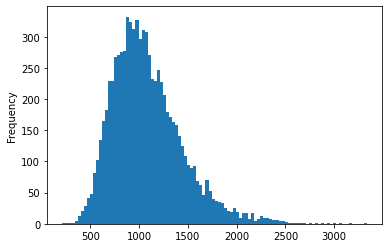

In [ ]:
df['len'].plot.hist(bins=100)

In [ ]:
#Count the text based on label.
count_df = df[['label','text']].groupby('label').aggregate({'text':'count'}).reset_index().sort_values('text',ascending=False)
count_df.head()

,label,text
60,recover_username,295
64,reset_2fa,286
59,recover_password,266
11,credit_card,219
79,status,216


In [ ]:
#Only get the label that has text >100
target_value = count_df[count_df['text']>100]['label'].values


In [ ]:
def condition_parser(x):
    if x in target_value:
        return x
    else:
        return "OTHER"
    
df['label'] = df['label'].apply(lambda x: condition_parser(x))  

In [ ]:
df = df[df['label']!='OTHER']

In [ ]:
import plotly.express as px

In [ ]:
px.bar(count_df[count_df['text']>100],x='label',y='text')

In [ ]:
import re
#Cleaning special characters
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x
#cleaning numbers
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [ ]:
#Removing contractions
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [ ]:
# lower the text
df["text"] = df["text"].apply(lambda x: x.lower())

# Clean the text
df["text"] = df["text"].apply(lambda x: clean_text(x))

# Clean numbers
df["text"] = df["text"].apply(lambda x: clean_numbers(x))

# Clean Contractions
df["text"] = df["text"].apply(lambda x: replace_contractions(x))


In [ ]:
df.head()

,text,label,len
0,"agent hi!,agent how can i help you?,customer h...",return_size,1308
1,"agent good afternoon, how can i help you?,cust...",refund_status,846
3,agent welcome to acmebrands! how can i help yo...,manage,976
5,"agent hello! how can i help you today?,custome...",manage_extension,911
6,"agent hello how can i help you today?,customer...",recover_username,995


In [ ]:
df['label'].unique()

array(['return_size', 'refund_status', 'manage', 'manage_extension',
       'recover_username', 'shopping_cart', 'status', 'credit_card',
       'slow_speed', 'status_quantity',
       'mistimed_billing_already_returned', 'status_due_date',
       'recover_password', 'manage_pay_bill', 'status_payment_method',
       'refund_update', 'search_results', 'refund_initiate',
       'return_color', 'missing', 'out_of_stock_general', 'reset_2fa',
       'bad_price_competitor', 'status_mystery_fee',
       'status_shipping_question', 'cost',
       'mistimed_billing_never_bought', 'status_delivery_time',
       'status_due_amount', 'manage_dispute_bill', 'status_service_added',
       'return_stain', 'bad_price_yesterday', 'promo_code_invalid',
       'status_service_removed'], dtype=object)

In [ ]:
#Split dataset
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df['text'], df['label'],
                                                    stratify=df['label'], 
                                                    test_size=0.25)

In [ ]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (4113,)
Test shape :  (1371,)


In [ ]:
df.head()

,text,label,len
0,"agent hi!,agent how can i help you?,customer h...",return_size,1308
1,"agent good afternoon, how can i help you?,cust...",refund_status,846
3,agent welcome to acmebrands! how can i help yo...,manage,976
5,"agent hello! how can i help you today?,custome...",manage_extension,911
6,"agent hello how can i help you today?,customer...",recover_username,995


In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences (Ensure that all sequences in a list have the same length)
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
#Convert string to numbers using LabelEncoder()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [ ]:
le.classes_

array(['bad_price_competitor', 'bad_price_yesterday', 'cost',
       'credit_card', 'manage', 'manage_dispute_bill', 'manage_extension',
       'manage_pay_bill', 'missing', 'mistimed_billing_already_returned',
       'mistimed_billing_never_bought', 'out_of_stock_general',
       'promo_code_invalid', 'recover_password', 'recover_username',
       'refund_initiate', 'refund_status', 'refund_update', 'reset_2fa',
       'return_color', 'return_size', 'return_stain', 'search_results',
       'shopping_cart', 'slow_speed', 'status', 'status_delivery_time',
       'status_due_amount', 'status_due_date', 'status_mystery_fee',
       'status_payment_method', 'status_quantity', 'status_service_added',
       'status_service_removed', 'status_shipping_question'], dtype=object)

In [ ]:
#Load Embeddings
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/Data/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(10000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [ ]:
np.shape(embedding_matrix)

(7801, 300)

In [ ]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 80
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit


In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

In [ ]:
n_epochs = 10
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-37-f01aef079cf9>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/10 	 loss=960.5736 	 val_loss=763.6853  	 val_acc=0.4493  	 time=12.84s
Epoch 2/10 	 loss=669.2805 	 val_loss=463.3095  	 val_acc=0.6441  	 time=3.18s
Epoch 3/10 	 loss=388.4736 	 val_loss=277.7824  	 val_acc=0.7659  	 time=3.20s
Epoch 4/10 	 loss=246.6579 	 val_loss=203.6828  	 val_acc=0.8177  	 time=3.23s
Epoch 5/10 	 loss=185.5498 	 val_loss=168.9489  	 val_acc=0.8425  	 time=3.23s
Epoch 6/10 	 loss=152.0781 	 val_loss=147.8337  	 val_acc=0.8694  	 time=3.24s
Epoch 7/10 	 loss=128.6867 	 val_loss=130.3469  	 val_acc=0.8862  	 time=3.25s
Epoch 8/10 	 loss=108.1091 	 val_loss=119.4116  	 val_acc=0.8935  	 time=3.27s
Epoch 9/10 	 loss=95.4392 	 val_loss=111.1539  	 val_acc=0.8877  	 time=3.27s
Epoch 10/10 	 loss=82.8082 	 val_loss=105.4447  	 val_acc=0.8935  	 time=3.29s


In [ ]:
torch.save(model,'textcnn_model')

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

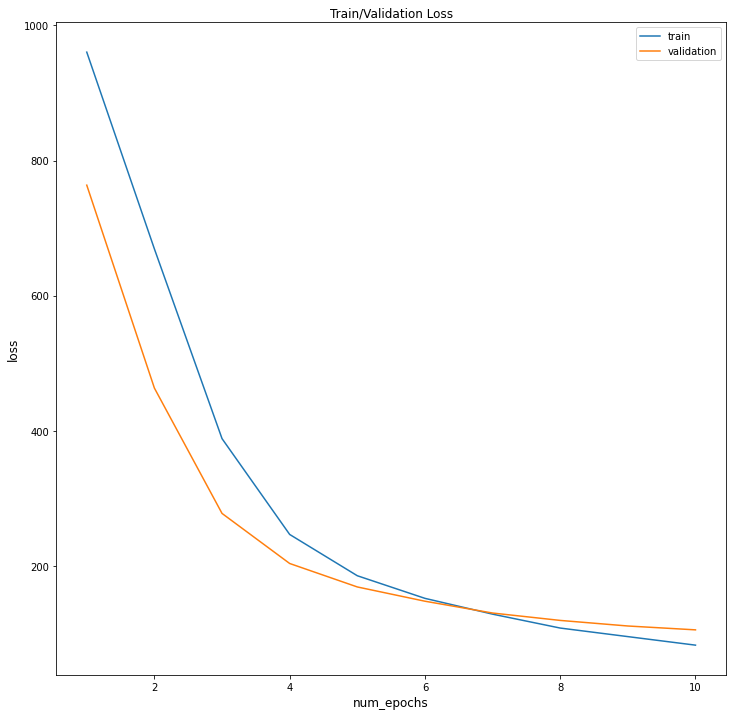

In [ ]:
plot_graph(n_epochs)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


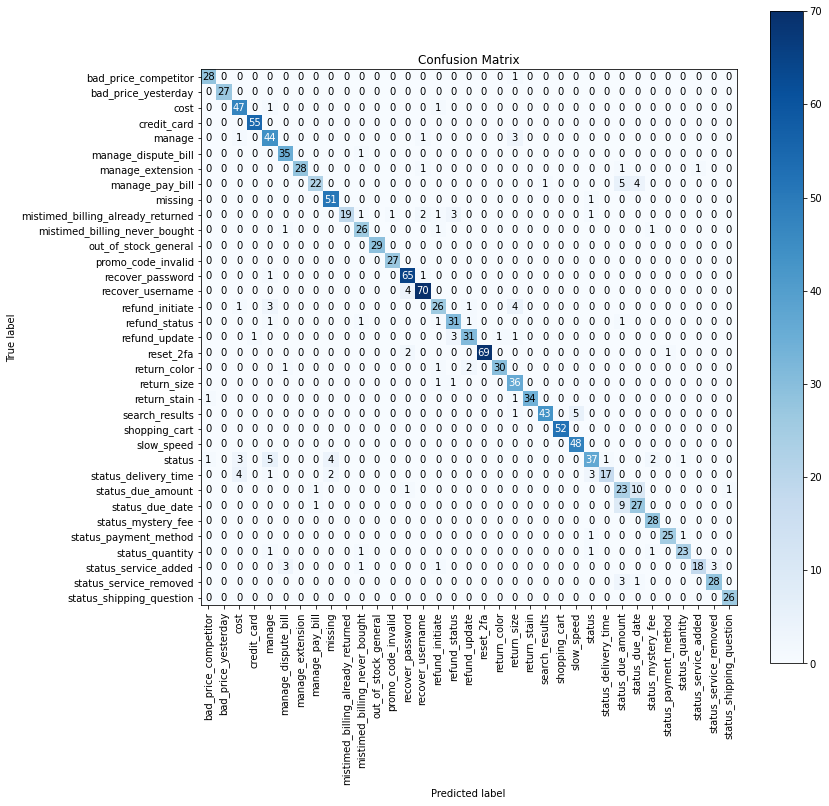

In [ ]:
!pip install scikit-plot
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 260
        drp = 0.5
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
n_epochs = 10
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-43-478f46a98030>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/10 	 loss=1038.8839 	 val_loss=959.2664  	 val_acc=0.0678  	 time=11.69s
Epoch 2/10 	 loss=1016.3457 	 val_loss=919.9336  	 val_acc=0.2079  	 time=10.77s
Epoch 3/10 	 loss=953.9601 	 val_loss=818.4106  	 val_acc=0.1575  	 time=10.89s
Epoch 4/10 	 loss=873.4164 	 val_loss=735.9858  	 val_acc=0.3239  	 time=10.97s
Epoch 5/10 	 loss=778.9442 	 val_loss=635.5641  	 val_acc=0.4318  	 time=11.14s
Epoch 6/10 	 loss=701.8020 	 val_loss=554.7999  	 val_acc=0.5222  	 time=11.16s
Epoch 7/10 	 loss=640.3238 	 val_loss=484.0545  	 val_acc=0.5748  	 time=11.29s
Epoch 8/10 	 loss=572.6747 	 val_loss=426.0916  	 val_acc=0.6441  	 time=11.49s
Epoch 9/10 	 loss=520.7658 	 val_loss=370.0460  	 val_acc=0.7009  	 time=11.62s
Epoch 10/10 	 loss=476.3277 	 val_loss=324.5819  	 val_acc=0.7374  	 time=11.82s


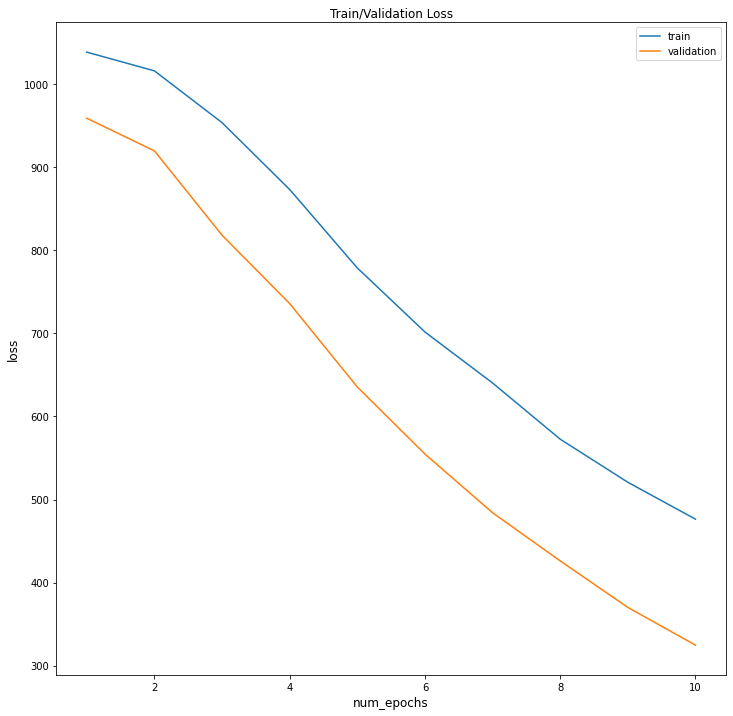

In [ ]:
plot_graph(n_epochs)

In [ ]:
torch.save(model,'bilstm_model')

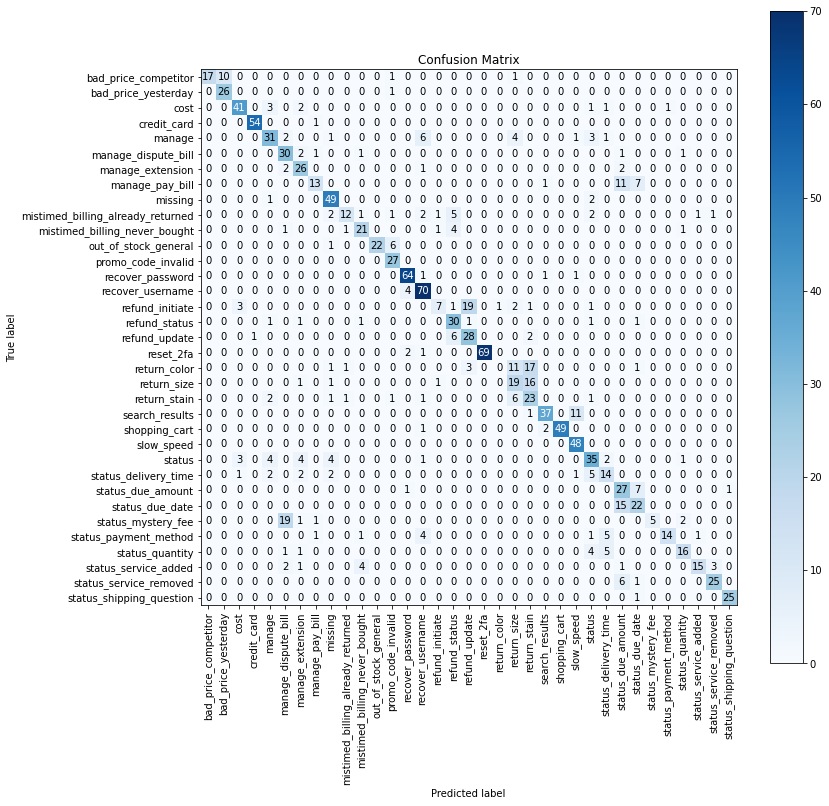

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [ ]:
x = df['text'].values[5]
print(x)

customer hello,agent hello! how can i help you today?,customer i am trying to buy a pair of boots but they are not getting added to my cart.,agent okay, i should be able to help you with that. one moment please...,agent can i get your name and account number first, please?,customer joseph banter, i do not have my account number but my username is josephb9,agent okay, that is fine. can you tell me the name of the product you had trouble with?,customer calvin klein boots,action searching the faq pages ...,action system action: search boots,action system action: search policy,action system action: search boots,action system action: search policy,action agent is looking for solutions ...,agent i am sorry, joseph. please stay with me here...,customer no problem,agent can i have you try refreshing the page, and then trying to put the boots in the cart again?,action agent is looking for solutions ...,customer sure, one moment,customer that did not work, sorry,action agent is looking for solut

In [ ]:
predict_single(x)

<ipython-input-47-eec990be84a5>:18: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



'shopping_cart'